# Benchmark Analysis

In [1]:
%cd ..

/home/rotaldf/projects/msc-thesis-code/activesecuritympc


/home/rotaldf/projects/msc-thesis-code/python_zkp_venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.transforms import Bbox
import numpy as np
import os

In [3]:
if not os.path.exists("figures"):
    os.makedirs("figures")

In [4]:
passive_readings = []
for i in range(3, 25):
    file = f"benchmarks/sum_passive_{i}_parties.csv"
    passive_readings.append(pd.read_csv(file))
passive_readings = pd.concat(passive_readings)
passive_readings['total_communication_cost'] = passive_readings['total_bytes_sent'] + passive_readings['total_bytes_recv']
passive_readings = passive_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

groth16_readings = []
for i in range(3, 25):
    file = f"benchmarks/sum_active_groth16_{i}_parties.csv"
    groth16_readings.append(pd.read_csv(file))
groth16_readings = pd.concat(groth16_readings)
groth16_readings['total_communication_cost'] = groth16_readings['total_bytes_sent'] + groth16_readings['total_bytes_recv']
groth16_readings['total_verification_time_per_party'] = groth16_readings['total_verification_time'] / groth16_readings['parties']
groth16_readings = groth16_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

bulletproofs_readings = []
for i in range(3, 25):
    file = f"benchmarks/sum_active_bulletproofs_{i}_parties.csv"
    bulletproofs_readings.append(pd.read_csv(file))
bulletproofs_readings = pd.concat(bulletproofs_readings)
bulletproofs_readings['total_communication_cost'] = bulletproofs_readings['total_bytes_sent'] + bulletproofs_readings['total_bytes_recv']
bulletproofs_readings['total_verification_time_per_party'] = bulletproofs_readings['total_verification_time'] / bulletproofs_readings['parties']
bulletproofs_readings = bulletproofs_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

parties = range(3,25)

In [5]:
def produce_plot(fig, ax, data, metric_dict, name, metric='runtime', id=0, semilog=False, marker='o', linestyle='-', color='0', loc='upper left'):
    # Calculate mean, median and stdiv for each id over ensemble
    grouped_data = data.groupby(['parties', 'id'])
    mean_data = grouped_data.mean()
    median_data = grouped_data.median()
    std_data = grouped_data.std()
    
    # Drop ensemble column
    mean_data = mean_data.drop(columns='ensemble')
    median_data = median_data.drop(columns='ensemble')
    std_data = std_data.drop(columns='ensemble')
    
    # Get data specifically for party 0
    median_data_0 = median_data[median_data.index.get_level_values('id') == id]
    mean_data_0 = mean_data[mean_data.index.get_level_values('id') == id]
    std_data_0 = std_data[std_data.index.get_level_values('id') == id]
    
    # Produce plot for a given metric
    parties = median_data_0.index.get_level_values('parties')
    data = median_data_0[metric]
    std_dev = std_data_0[metric]

    ax.errorbar(parties, data, yerr=std_dev, marker=marker, linestyle=linestyle, linewidth=1, capsize=3, markersize=6, color=color, label=name)
    ax.minorticks_on()
    if semilog:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale
        # Add major grid lines for better readability
        ax.yaxis.grid(True, linestyle='-', alpha=0.3)
        # Add minor grid lines as dotted lines
        ax.yaxis.grid(which='minor', linestyle='--', alpha=0.15)
    ax.xaxis.set_major_locator(AutoLocator())
    ax.set_xlim(3-0.5, max(parties)+0.5)
    ax.set_xlabel('parties', fontsize=12)
    ax.set_ylabel(metric_dict[metric], fontsize=10)
    if name:
        ax.legend(loc=loc, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    
    return fig, ax, data

In [6]:
names = {
    "total_zkp_constraints": "constraints",
    "total_zkp_compile_time": "time (sec)",
    "total_proof_size": "size (bytes)",
    "total_proving_time": "time (sec)",
    "total_crs_generation_time": "time (sec)",
    "total_crs_len": "size (bytes)",
    "total_verification_time": "time (sec)",
    "total_verification_time_per_party": "time (sec)",
    "cache_size": "size (bytes)",
    "total_runtime": "time (sec)",
    "total_communication_cost": "data (bytes)",
    "setup_time": "time (sec)",
    "engagement_time": "time (sec)",
    "emulation_time": "time (sec)",
    "total_communication_time": "time (sec)",
}

## Analysis

We start with the basics, i.e. overall runtime and communication cost for passive, active (groth16) and active (bulletproofs), as well as storage/memory usage for active (groth16) and active (bulletproofs)

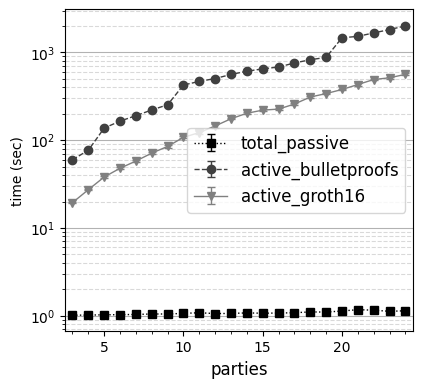

In [24]:
# Total runtime
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "total_passive", "total_runtime", marker='s', linestyle='dotted', color='0', loc='best')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "active_bulletproofs", "total_runtime", marker='o', linestyle='--', color='0.25', loc='best')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16", "total_runtime", marker='v', linestyle='-', color='0.5', loc='best', semilog=True)
fig.savefig('figures/total_runtime.pdf')

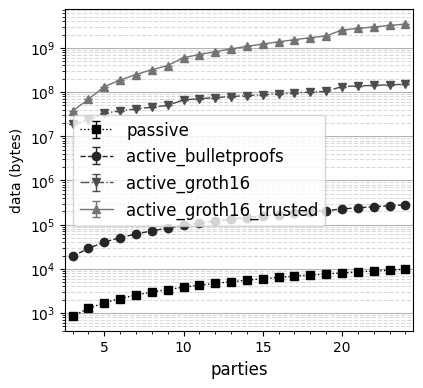

In [8]:
# Total communication cost
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "passive", "total_communication_cost", marker='s', linestyle='dotted', color='0', loc='best')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "active_bulletproofs", "total_communication_cost", marker='o', linestyle='--', color='0.15', loc='best')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16", "total_communication_cost", id=1, marker='v', linestyle='-.', color='0.3', loc='best')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16_trusted", "total_communication_cost", marker='^', linestyle='-', color='0.45', loc='best', semilog=True)
# plt.subplots_adjust(left=0.15)
fig.savefig('figures/total_communication_cost.pdf')

Clearly active security is far more expensive than passive security
* regarding the runtime, it at least 1 and upwards of 2 orders of magnitude slower (groth < bulletproofs differ by half order of magnitude), and follows an exponential trend.
* regarding communication cost, active security using bulletproofs is a bit over 1 order of magnitude more expensive and follows a linear trend. Active security using groth16 is over 4 orders of magnitude more expensive when it is not the trusted party, and becomes increasingly more expensive when it is.

The last thing we want to look at in terms of overall performance, is the total cache storage that is required by the active security compiler

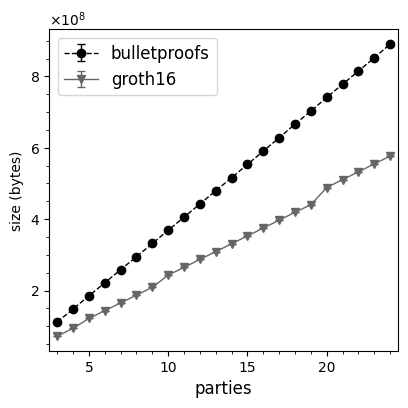

In [9]:
# Cache (memory) size
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "cache_size", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "cache_size", marker='v', linestyle='-', color='0.4', semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.savefig('figures/active_cache.pdf')

### Breakdown of runtime over the different active security compiler phases

To understand why active security with bulletproofs requires more computation time, let's break down the runtime analysis into its parts

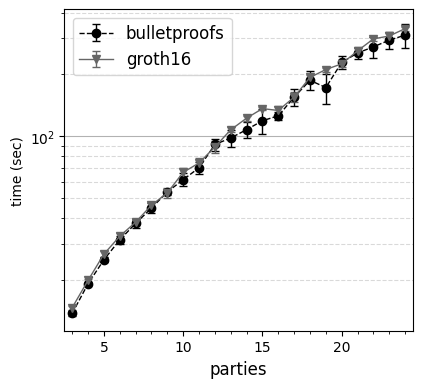

In [10]:
# Setup time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "setup_time", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "setup_time", marker='v', linestyle='-', color='0.4', semilog=True)
fig.savefig('figures/active_setup_time.pdf')

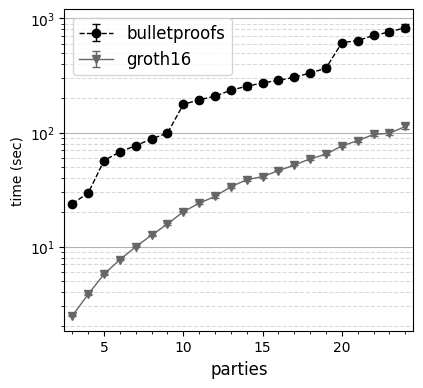

In [11]:
# Engagement time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "engagement_time", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "engagement_time", marker='v', linestyle='-', color='0.4', semilog=True)
fig.savefig('figures/active_engagement_time.pdf')

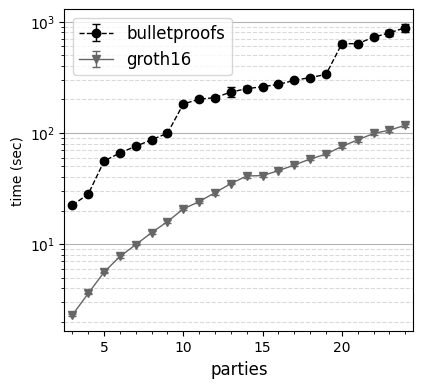

In [12]:
# Emulation time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "emulation_time", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "emulation_time", marker='v', linestyle='-', color='0.4', semilog=True)
fig.savefig('figures/active_emulation_time.pdf')

For the setup phase, it appears that both groth16 and bulletproofs are quite similar, but groth16 is a bit slower due to the trusted setup. Moreover, engagement and emulation are both similar where active security with bulletproofs is about 1 order of magnitude slower than with groth16.

### Breakdown of setup phase

We measure the runtime and size of the components in setup phase, more specifically the ZKP compilation runtime and number of constraints, and the CRS generation runtime and size:

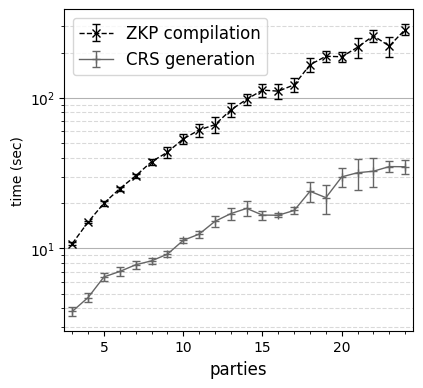

In [13]:
# Total CRS generation and ZKP compilation time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "ZKP compilation", "total_zkp_compile_time", marker='x', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "CRS generation", "total_crs_generation_time", marker='+', linestyle='-', color='0.4', semilog=True)
fig.savefig('figures/zkp_comp_crs_gen.pdf')

We see that ZKP compilation time has an exponential trend, while CRS generation time seems to follow more of a linear trend

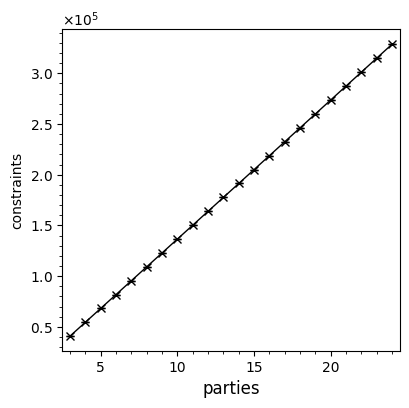

In [14]:
# Total ZKP constraints
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "", "total_zkp_constraints", marker='x', semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.subplots_adjust(left=0.15)
fig.savefig('figures/constraints_count.pdf')

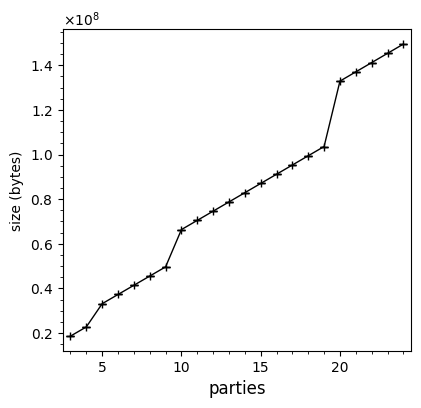

In [15]:
# Total CRS length
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "", "total_crs_len", marker='+', semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.savefig('figures/crs_length.pdf')

ZKP constraints are clearly linear with party size, while CRS length is linear but has steep increments at m=5, m=9 and m=20

### Breakdown of engagement and emulation phase

Both engagement and emulation essentially are limited by the ZKP proofs and verifications.  We inspect the components as follows

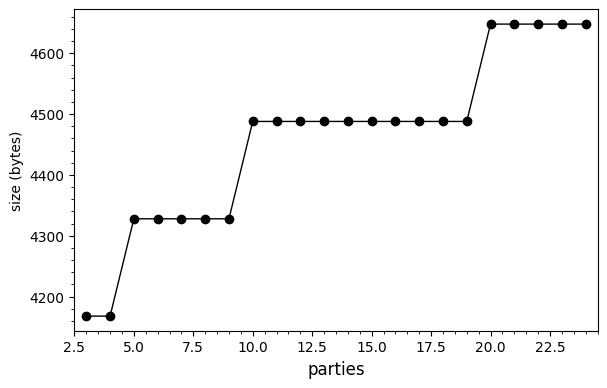

In [16]:
# Total CRS length and ZKP constraints
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
# fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_proof_size", marker='o', semilog=False)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_proof_size", marker='o')
fig.savefig('figures/active_bulletproofs_proof_size.pdf')

Groth16 always produces constant size proofs, whereas Bulletproofs are sublinear in the size of number of constraints

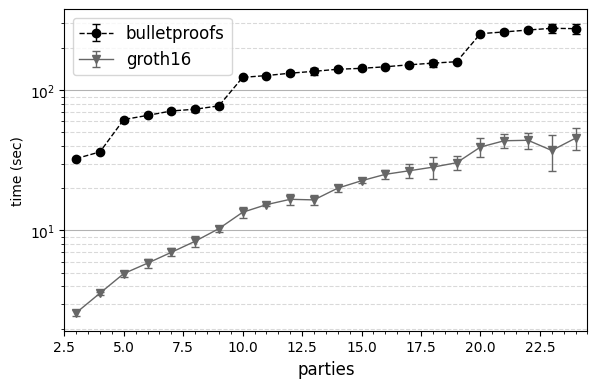

In [17]:
# Total proving time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_proving_time", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_proving_time", marker='v', linestyle='-', color='0.4', semilog=True)
fig.savefig('figures/active_proving_time.pdf')

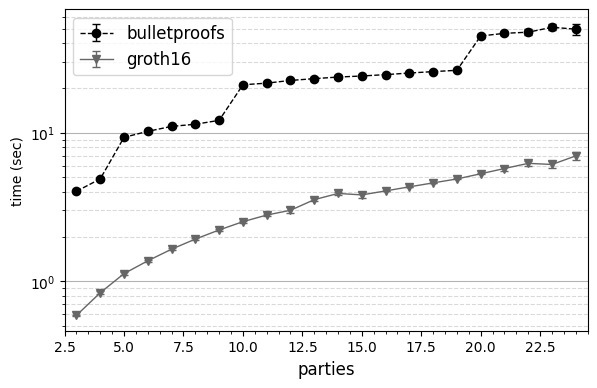

In [18]:
# Total verification time per party
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_verification_time_per_party", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_verification_time_per_party", marker='v', linestyle='-', color='0.4', semilog=True)
fig.savefig('figures/active_verification_time.pdf')

### Relative runtimes

In [19]:
def get_runtime_ratio(data, metric_dict, metric='runtime', id=0):
    # Compute a new column based on metric divided by total_runtime
    data['metric_ratio'] = data[metric] / data['total_runtime']
    
    # Calculate mean, median, and stdiv for the new column
    grouped_data_ratio = data.groupby(['parties', 'id'])
    mean_data_ratio = grouped_data_ratio['metric_ratio'].mean()
    median_data_ratio = grouped_data_ratio['metric_ratio'].median()
    std_data_ratio = grouped_data_ratio['metric_ratio'].std()
    
    # Get data specifically for party 0
    mean_data_0 = mean_data_ratio[mean_data_ratio.index.get_level_values('id') == id]
    median_data_0 = median_data_ratio[median_data_ratio.index.get_level_values('id') == id]
    std_data_0 = std_data_ratio[std_data_ratio.index.get_level_values('id') == id]
    
    # Produce plot for a given metric
    parties = median_data_0.index.get_level_values('parties')
    data = median_data_0
    std_dev = std_data_0

    return data

Lastly we measure how all components compare against the overall runtime and communication cost to see which is the bottleneck.

Runtime contributions:
* Components percentage plot: total_zkp_compile_time, total_crs_generation_time, total_proving_time, total_verification_time, remainder
* Phases percentage plot: setup_time, engagement_time, emulation_time, remainder

for cache it is kind of useless due to serialization of components, and for communication we only compare proof size to crs size (which depend on each other), so also not interesting.

#### Groth16

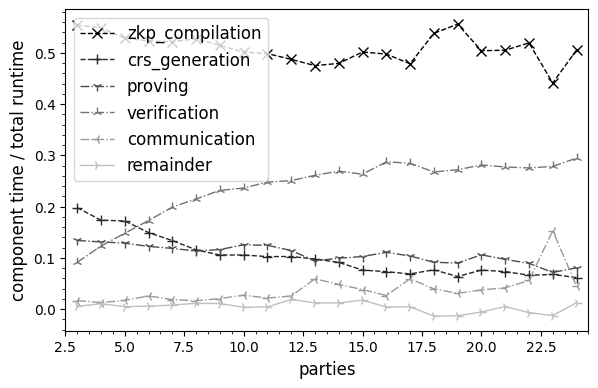

In [20]:
# For different components
zkp_compile_time_ratio = get_runtime_ratio(groth16_readings, names, "total_zkp_compile_time")
crs_generation_time_ratio = get_runtime_ratio(groth16_readings, names, "total_crs_generation_time")
proving_time_ratio = get_runtime_ratio(groth16_readings, names, "total_proving_time")
verification_time_ratio = get_runtime_ratio(groth16_readings, names, "total_verification_time")
communication_time_ratio = get_runtime_ratio(groth16_readings, names, "total_communication_time")

remainder_ratio = 1 - (zkp_compile_time_ratio + crs_generation_time_ratio + proving_time_ratio + verification_time_ratio + communication_time_ratio)

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.plot(parties, zkp_compile_time_ratio, linestyle="--", linewidth=1, color='0', marker="x", markersize=7, label="zkp_compilation")
plt.plot(parties, crs_generation_time_ratio, linestyle="--", linewidth=1, color='0.15', marker="+", markersize=7, label="crs_generation")
plt.plot(parties, proving_time_ratio, linestyle="-.", linewidth=1, color='0.3', marker="1", markersize=7, label="proving")
plt.plot(parties, verification_time_ratio, linestyle="-.", linewidth=1, color='0.45', marker="2", markersize=7, label="verification")
plt.plot(parties, communication_time_ratio, linestyle="-.", linewidth=1, color='0.6', marker="3", markersize=7, label="communication")
plt.plot(parties, remainder_ratio, linestyle="-", linewidth=1, color='0.75', marker="4", markersize=7, label="remainder")
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('component time / total runtime', fontsize=12)
plt.legend(loc='best', fontsize=12)

plt.savefig('figures/groth16_relative_component_times.pdf')

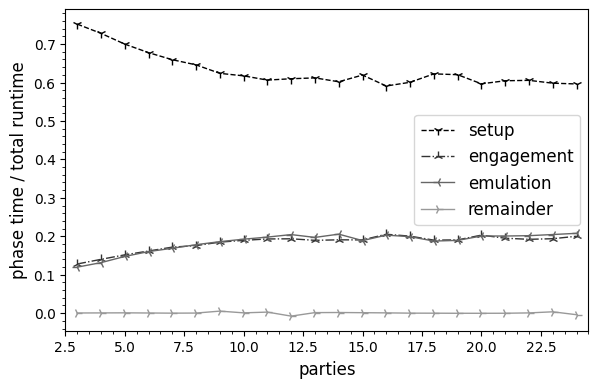

In [21]:
# For different phases
setup_time_ratio = get_runtime_ratio(groth16_readings, names, "setup_time")
engagement_time_ratio = get_runtime_ratio(groth16_readings, names, "engagement_time")
emulation_time_ratio = get_runtime_ratio(groth16_readings, names, "emulation_time")

remainder_ratio = 1 - (setup_time_ratio + engagement_time_ratio + emulation_time_ratio)

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.plot(parties, setup_time_ratio, linestyle="--", linewidth=1, color='0', marker="1", markersize=7, label="setup")
plt.plot(parties, engagement_time_ratio, linestyle="-.", linewidth=1, color='0.2', marker="2", markersize=7, label="engagement")
plt.plot(parties, emulation_time_ratio, linestyle="-", linewidth=1, color='0.4', marker="3", markersize=7, label="emulation")
plt.plot(parties, remainder_ratio, linestyle="-", linewidth=1, color='0.6', marker="4", markersize=7, label="remainder")
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('phase time / total runtime', fontsize=12)
plt.legend(loc='best', fontsize=12)

plt.savefig('figures/groth16_relative_phases_times.pdf')

#### Bulletproofs

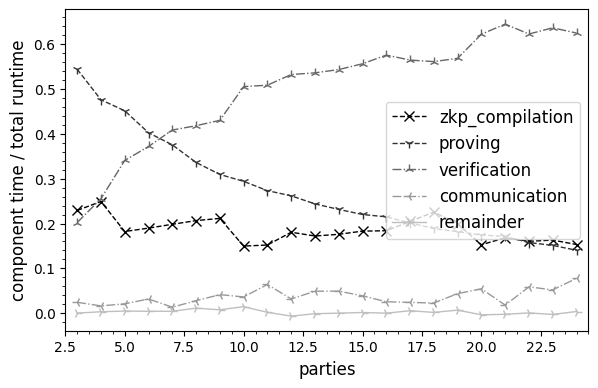

In [22]:
# For different components
zkp_compile_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_zkp_compile_time")
proving_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_proving_time")
verification_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_verification_time")
communication_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_communication_time")

remainder_ratio = 1 - (zkp_compile_time_ratio + proving_time_ratio + verification_time_ratio + communication_time_ratio)

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.plot(parties, zkp_compile_time_ratio, linestyle="--", linewidth=1, color='0', marker="x", markersize=7, label="zkp_compilation")
plt.plot(parties, proving_time_ratio, linestyle="--", linewidth=1, color='0.2', marker="1", markersize=7, label="proving")
plt.plot(parties, verification_time_ratio, linestyle="-.", linewidth=1, color='0.4', marker="2", markersize=7, label="verification")
plt.plot(parties, communication_time_ratio, linestyle="-.", linewidth=1, color='0.6', marker="3", markersize=7, label="communication")
plt.plot(parties, remainder_ratio, linestyle="-", linewidth=1, color='0.75', marker="4", markersize=7, label="remainder")
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('component time / total runtime', fontsize=12)
plt.legend(loc='center right', fontsize=12)

plt.savefig('figures/bulletproofs_relative_component_times.pdf')

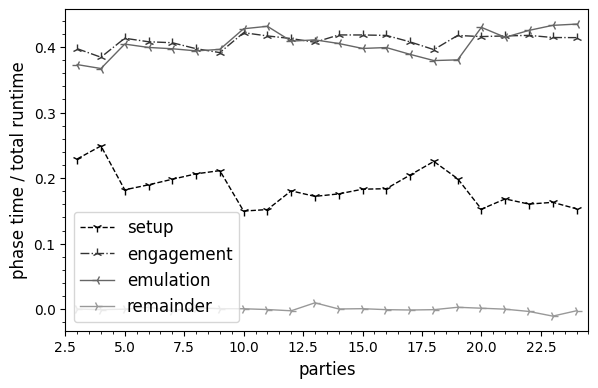

In [23]:
# For different phases
runtime_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_runtime")
setup_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "setup_time")
engagement_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "engagement_time")
emulation_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "emulation_time")

remainder_ratio = 1 - (setup_time_ratio + engagement_time_ratio + emulation_time_ratio)

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.plot(parties, setup_time_ratio, linestyle="--", linewidth=1, color='0', marker="1", markersize=7, label="setup")
plt.plot(parties, engagement_time_ratio, linestyle="-.", linewidth=1, color='0.2', marker="2", markersize=7, label="engagement")
plt.plot(parties, emulation_time_ratio, linestyle="-", linewidth=1, color='0.4', marker="3", markersize=7, label="emulation")
plt.plot(parties, remainder_ratio, linestyle="-", linewidth=1, color='0.6', marker="4", markersize=7, label="remainder")
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('phase time / total runtime', fontsize=12)
plt.legend(loc='lower left', fontsize=12)

plt.savefig('figures/bulletproofs_relative_phases_times.pdf')